<a href="https://colab.research.google.com/github/mirsaidl/Pneumonia-classification-cnn/blob/main/tensorflow_tf_97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### What is Pneumonia?

Pneumonia is an infection that inflames the air sacs in one or both lungs. It kills more children younger than 5 years old each year than any other infectious disease, such as HIV infection, malaria, or tuberculosis. Diagnosis is often based on symptoms and physical examination. Chest X-rays may help confirm the diagnosis.

### About Dataset
This dataset contains 5,856 validated Chest X-Ray images. Images are labeled as (disease:NORMAL/PNEUMONIA)-(randomized patient ID)-(image number of a patient).

The images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou.

Note: Data was downloaded from Kaggle to Google Colab. Below code is default code for downloading by kaggle

In [1]:
# @title
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'labeled-chest-xray-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F835414%2F1426603%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240324%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240324T134146Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D28b9fd59b6cd78b69f5efa3b95fee1ba93d4be16375035c1303928dad7e48873159f42a9a68b803b113cd884fb6df17c49eb13b2f9f0785b2fcf028abcb40e97edcb1a350fdc9dc3155b05e6140b81088e0936d5d2360f7d6fe52adc9d856570b1d760521bdc215a89aa379f3d536841d48c704e579d5e4ba4f1a336dab42b850d487d6d3e0abbc687ed748550f59bd519359f81b5f471b56ab0f7168df821e6d519e5a5d99e2fdcd0199694b60eb5c8553a50b2c5f71838b7a6b02217f7553ab4a85c1fc1613fb4489a4d6ab407de9a5dbee474ba8664a46de99efbd51643065d810874d42f78c3b3725b5a2c21478291f35f08bea08cd4c76cf33c6e7475a7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1257855648 bytes downloaded
Downloaded and uncompressed: labeled-chest-xray-images
Data source import complete.


In [32]:
import tensorflow as tf
import numpy as np

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers.experimental.preprocessing import Normalization, RandomFlip, RandomRotation, RandomCrop
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop, RandomZoom, RandomContrast
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [21]:
# Train set
train_dataset = image_dataset_from_directory('/input/labeled-chest-xray-images/chest_xray',
                                             subset='training',
                                             seed=45,
                                             validation_split=0.15,
                                             batch_size=128,
                                             image_size=(256, 256))

Found 5232 files belonging to 2 classes.
Using 4448 files for training.


In [22]:
# Test set
# Note: 15% of data for test/validation
test_dataset = image_dataset_from_directory('/input/labeled-chest-xray-images/chest_xray',
                                                  subset='validation',
                                                  seed=42,
                                                  validation_split=0.15,
                                                  batch_size=128,
                                                  image_size=(256, 256))

Found 5232 files belonging to 2 classes.
Using 784 files for validation.


In [7]:
# Number of classes
class_names = train_dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

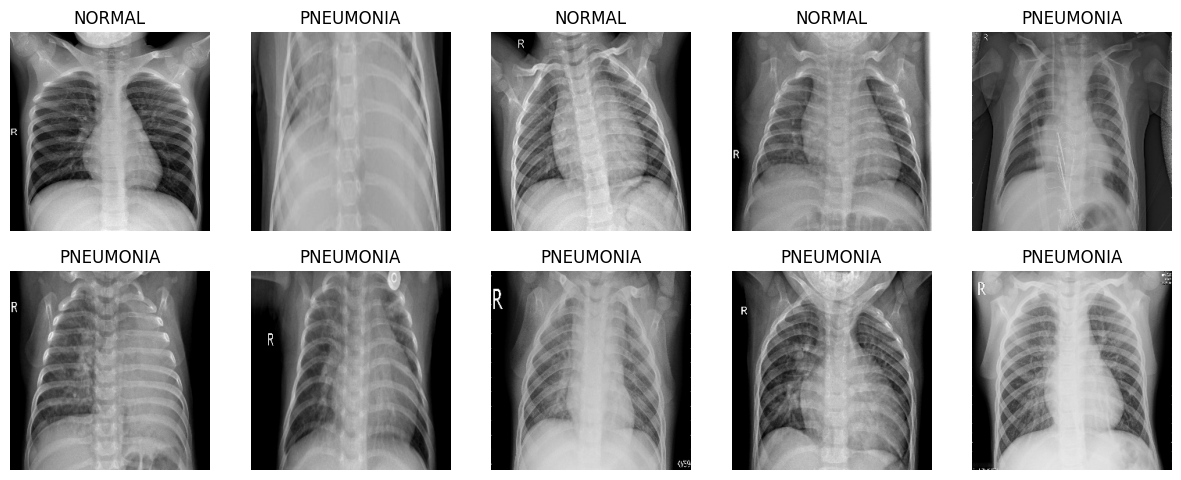

In [13]:
# Display some pictures
plt.figure(figsize=(15, 15))
for images, labels in train_dataset.take(1):
    for i in range(10):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
# Data Augmentation
data_augmentation = Sequential()
data_augmentation.add(RandomFlip("horizontal"))
data_augmentation.add(RandomRotation(0.1))
data_augmentation.add(RandomZoom(0.1))
data_augmentation.add(RandomContrast(0.1))

In [16]:
# Transfer Learning model InceptionV3
base_inception = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))

87910968/87910968 [==============================] - 4s 0us/step


In [17]:
# Model Architecture
model = Sequential()
model.add(data_augmentation) # augmentation
model.add(Normalization())
model.add(base_inception) # InceptionV3
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names), activation='softmax'))

In [18]:
model_save_path = './best_model.h5'

# Callback that saves the best val_accuracy as .h5 file
checkpoint_callback = ModelCheckpoint(model_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [19]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=10,
                    callbacks=[checkpoint_callback])

Epoch 1/10
35/35 [==============================] - ETA: 0s - loss: 0.1322 - accuracy: 0.9661
Epoch 1: val_accuracy improved from 0.90153 to 0.95026, saving model to ./best_model.h5
35/35 [==============================] - 86s 2s/step - loss: 0.1322 - accuracy: 0.9661 - val_loss: 0.1299 - val_accuracy: 0.9503
Epoch 2/10
35/35 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.9732
Epoch 2: val_accuracy improved from 0.95026 to 0.96684, saving model to ./best_model.h5
35/35 [==============================] - 77s 2s/step - loss: 0.1185 - accuracy: 0.9732 - val_loss: 0.0995 - val_accuracy: 0.9668
Epoch 3/10
35/35 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.9759
Epoch 3: val_accuracy did not improve from 0.96684
35/35 [==============================] - 62s 2s/step - loss: 0.1209 - accuracy: 0.9759 - val_loss: 0.2952 - val_accuracy: 0.8342
Epoch 4/10
35/35 [==============================] - ETA: 0s - loss: 0.1118 - accuracy: 0.9753
Epoch 4: v

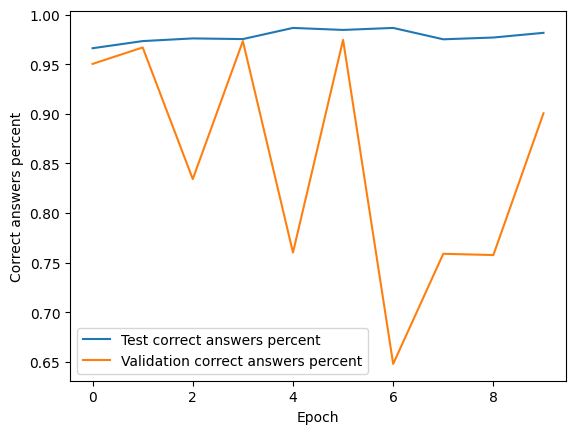

In [24]:
plt.plot(history.history['accuracy'],
         label='Test correct answers percent')
plt.plot(history.history['val_accuracy'],
         label='Validation correct answers percent')
plt.xlabel('Epoch')
plt.ylabel('Correct answers percent')
plt.legend()
plt.show()

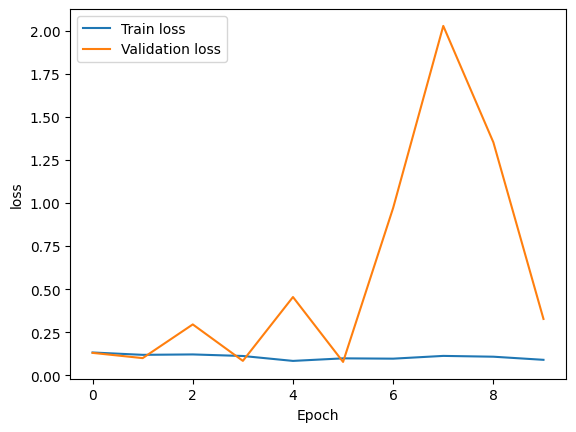

In [25]:
plt.plot(history.history['loss'],
         label='Train loss')
plt.plot(history.history['val_loss'],
         label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [26]:
# Path to the saved .h5 model
model_path = '/content/best_model.h5'
# Load the model
loaded_model = tf.keras.models.load_model(model_path)

In [31]:
score_test = loaded_model.evaluate(test_dataset)
score_train = loaded_model.evaluate(train_dataset)

print('Current Accuracy for Test set: ', np.floor(score_test[1]*100), '%')
print('Current Accuracy for Train set: ', np.floor(score_train[1]*100), '%')

35/35 [==============================] - 34s 772ms/step - loss: 0.0628 - accuracy: 0.9804
Current Accuracy for Test set:  97.0 %
Current Accuracy for Train set:  98.0 %
